# Neural Network (Classification)

[Naive implementation](#naive-implementation)  
[Keras](#Keras)

## The data

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


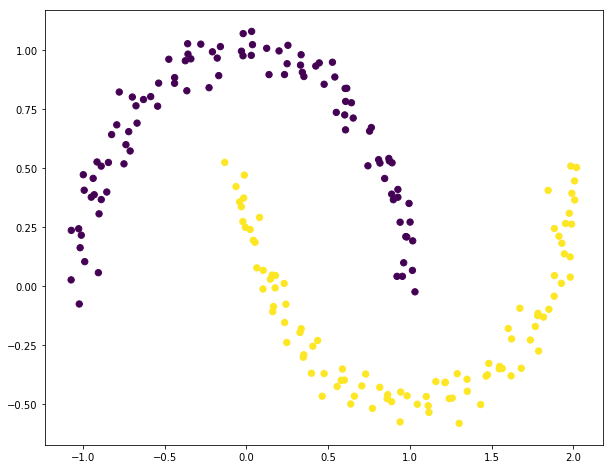

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.05)
plt.scatter(X[:,0], X[:,1], s=40, c=y)


## Naive Implementation

In [2]:
from sklearn.neural_network._base import softmax

alpha = 0.01
lambda_ = 0.01


def _feed_forward(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    o = softmax(z2)
    return o, {"z1": z1, "a1": a1, "z2": z2}

    
def predict(model, X):
    output, _ = _feed_forward(model, X)
    return np.argmax(output, axis=1)

def loss_function(model, X, y):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    o, _ = _feed_forward(model, X)
    
    reg_term = lambda_/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2))) 
    data_loss = np.sum(-np.log(o[range(len(X)), y]))
    data_loss += reg_term
    data_loss = data_loss / X.shape[0]
    
    return data_loss
    

def train_model(X, y, hidden_size, epochs=20000):
    input_size = X.shape[1]
    output_size = 2
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
    b2 = np.zeros((1, output_size))
    
    model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

    for i in range(0, epochs):
        o, cache = _feed_forward(model, X)
        
        # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
        # delta3 = o - y
        delta3 = o
        delta3[range(len(X)), y] -= 1
        delta2 = delta3.dot(W2.T) * (1 - np.power(cache["a1"], 2))
                
        dW2 = cache["a1"].T.dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        dW2 += lambda_ * W2
        dW1 += lambda_ * W1
        
        W2 += -alpha * dW2
        W1 += -alpha * dW1
        b2 += -alpha * db2
        b1 += -alpha * db1
        
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        if i % 1000 == 0:
            print(loss_function(model, X, y))
            # print(b2, b1)
        
    return model


0.41886789635417593
0.004859957006923416


0.004636019624475354


0.004600056169688691


0.004587661735283828
0.004581521801568179


0.004577938361415669
0.004575660955264387


0.004574131562016374
0.004573061985719588


0.004572290285201873
0.004571719846949773


0.004571290139587795
0.004570961614166063


0.004570707486398872
0.0045705090586366


0.004570352944502105
0.004570229357777641


0.00457013101955691
0.004570052437797104


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


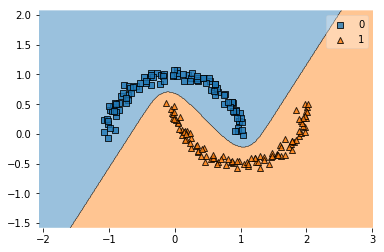

In [3]:
hidden_size = 3
model = train_model(X, y, hidden_size)

from mlxtend.plotting import plot_decision_regions
# a dummy class to "do the trick" with 'plot_decision_regions'
class Classifier():

    def predict(self, X):
        return predict(model, X)

plot_decision_regions(X, y, clf=Classifier())

## Keras

In [10]:
import keras
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

from keras import optimizers
from keras.layers import Dense, Softmax
from keras.optimizers import Adam


input_size = 2
hidden_size = 3
output_size = 2
y_train = np.zeros((y.size, 2))
y_train[range(len(y)), y] = 1

model = keras.Sequential()
model.add(Dense(hidden_size, input_dim=input_size, use_bias=True, 
                kernel_initializer=keras.initializers.glorot_normal(seed=None),
                bias_initializer="zeros", activation="tanh"))
model.add(Dense(output_size, use_bias=True, 
                kernel_initializer=keras.initializers.glorot_normal(seed=None), 
                bias_initializer="zeros"))
model.add(Softmax(output_size))


sgd = optimizers.SGD(lr=0.05)
model.compile(sgd, loss="binary_crossentropy")
model.summary()

history = model.fit(X, y_train, epochs=2000, verbose=0)
print("last loss: ", history.history["loss"][-1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 8         
_________________________________________________________________
softmax_4 (Softmax)          (None, 2)                 0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


last loss:  0.00605292621999979


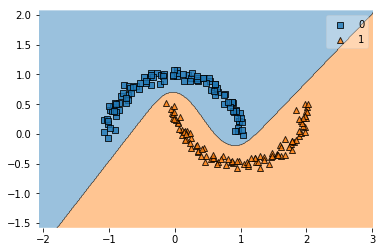

In [ ]:
class Wrapper():
    def predict(self, X):
        y_pred = model.predict(X)
        y = np.argmax(y_pred, axis=1)
        return y
    
plot_decision_regions(X, y, clf=Wrapper())